# Issue 1520

[Issue 1520](https://github.com/ebmdatalab/openprescribing/issues/1520) discusses a longstanding bug in the code that calculates measure values for CCGs, affects any measures whose denominator is derived from the `practice_statistics` table.

This notebook attempts to quantify the impact of this bug.

In summary: there are noticeable differences in the ratios and percentiles for a handful of pairs of measures/CCGs.

### Setup

In [1]:
%matplotlib inline

In [2]:
import glob
from IPython.display import HTML, display
import pandas as pd
import matplotlib.pyplot as plt

### Getting the data

For now, the data from the old versions of the calculations are in BQ in tables called `ccg_data_{measure_id}`, while data from the new versions are in `ccg_data_{measure_id}_1520`.

We do one query per measure, and concatenate the results in a single `DataFrame`.

In [3]:
project_id = 'ebmdatalab'

In [4]:
sql = '''
SELECT
    '{measure_id}' AS measure_id,
    CONCAT(
        CAST(EXTRACT(YEAR FROM t0.month) AS STRING),
        "_",
        LPAD(CAST(EXTRACT(MONTH FROM t0.month) AS STRING), 2, "0")
    ) AS month,
    t0.pct_id AS ccg_id,
    t0.calc_value AS ratio0,
    t1.calc_value AS ratio1,
    t0.percentile AS percentile0,
    t1.percentile AS percentile1
FROM measures.ccg_data_{measure_id} t0
INNER JOIN measures.ccg_data_{measure_id}_1520 t1
    ON t0.month = t1.month AND t0.pct_id = t1.pct_id
ORDER BY ccg_id, month
'''

In [5]:
measure_ids = [
    path.split('/')[-1].split('.')[0]
    for path in glob.glob(
        '/Users/inglesp/work/ebmdatalab/openprescribing/openprescribing'
        '/frontend/management/commands/measure_definitions/*.json'
    )
]

In [6]:
df = pd.concat([
    pd.read_gbq(
        sql.format(measure_id=measure_id),
        project_id=project_id, 
        dialect='standard'
    ).set_index(['measure_id', 'ccg_id', 'month'])
    for measure_id in measure_ids
])

In [7]:
df.shape

(818805, 4)

In [8]:
df.head()

ratio0    ratio1  percentile0  percentile1
measure_id ccg_id month                                                
ace        00C    2014_01  0.001654  0.001654     0.123711     0.123711
                  2014_02  0.001648  0.001648     0.118557     0.118557
                  2014_03  0.002362  0.002362     0.309278     0.309278
                  2014_04  0.001949  0.001949     0.211340     0.211340
                  2014_05  0.002439  0.002439     0.324742     0.324742

### Calculating the differences

For each measure/CCG/month, we can calculate the absolute difference between the percentiles calculated with the old method and the new method.

We can then:

* see which measures/CCGs are most affected by summing over months
* see which measures are most affected by summing over months/CCGs
* see which CCGs are most affected by summing over months/measures

In [9]:
percentile_diff = abs(df['percentile0'] - df['percentile1'])

In [10]:
def display_table(df):
    display(HTML(df.reset_index(name='diff').to_html(index=False)))

In [11]:
display_table(percentile_diff.sort_values(ascending=False).head(20))

measure_id,ccg_id,month,diff
lphomeopathy,00R,2018_07,0.809278
lphomeopathy,06N,2018_04,0.664948
lpherbal,00R,2018_07,0.561856
lphomeopathy,08Q,2017_01,0.505155
ktt9_antibiotics,00R,2018_04,0.479381
ktt9_antibiotics,00R,2017_05,0.474227
ktt9_antibiotics,00R,2017_12,0.463918
ktt9_antibiotics,00R,2018_08,0.458763
ktt9_antibiotics,00R,2018_02,0.427835
ktt9_antibiotics,00R,2018_06,0.391753


In [12]:
percentile_diff_by_measure_and_ccg = percentile_diff.groupby(['measure_id', 'ccg_id']).sum()

In [13]:
display_table(percentile_diff_by_measure_and_ccg.sort_values(ascending=False).head(10))

measure_id,ccg_id,diff
ktt9_antibiotics,00R,10.329897
ktt9_antibiotics,02H,5.077320
ktt9_antibiotics,99N,4.345361
ktt9_cephalosporins_star,00R,4.309278
ktt9_antibiotics,01T,4.103093
ktt9_antibiotics,04Y,2.701031
ktt9_antibiotics,02E,2.628866
ktt9_cephalosporins_star,01T,2.262887
ktt9_antibiotics,01D,1.850515
ktt9_cephalosporins_star,02H,1.505155


In [14]:
percentile_diff_by_measure = percentile_diff.groupby(['measure_id']).sum()

In [15]:
display_table(percentile_diff_by_measure.sort_values(ascending=False).head(10))

measure_id,diff
ktt9_antibiotics,85.072165
ktt9_cephalosporins_star,40.103093
lpneedles,12.453608
fungal,11.690722
tamoxifen,11.690722
lpminocycline,9.721649
bdzper1000,9.515464
test_strip,9.432990
lpbathshoweremollients,9.175258
opioidome,8.958763


In [16]:
percentile_diff_by_ccg = percentile_diff.groupby(['ccg_id']).sum()

In [17]:
display_table(percentile_diff_by_ccg.sort_values(ascending=False).head(10))

ccg_id,diff
02E,19.510309
00R,17.319588
02H,7.417526
01T,7.268041
99N,7.103093
10K,6.675258
06T,5.123711
04Y,4.505155
10J,4.170103
11N,3.958763


### Visualising the differences

We can plot the difference in ratios and percentiles for any measure/CCG pair.

For the measure/CCG with the tenth highest summed difference, there is little noticeable discrepancy.

In [18]:
def plot_ratios_and_percentiles(df, measure_id, ccg_id):
    df1 = df.loc[measure_id, ccg_id].unstack()

    fig = plt.figure()
    ax1 = fig.add_axes([0, 0, 0.8, 0.4])
    ax2 = fig.add_axes([1, 0, 0.8, 0.4], ylim=(0, 1))

    pd.DataFrame({
        'old': df1['ratio0'],
        'new': df1['ratio1'],
    }).plot(
        ax=ax1,
        title=f'{measure_id} {ccg_id} ratios'
    )
    
    pd.DataFrame({
        'old': df1['percentile0'],
        'new': df1['percentile1'],
    }).plot(
        ax=ax2,
        title=f'{measure_id} {ccg_id} percentiles'
    );

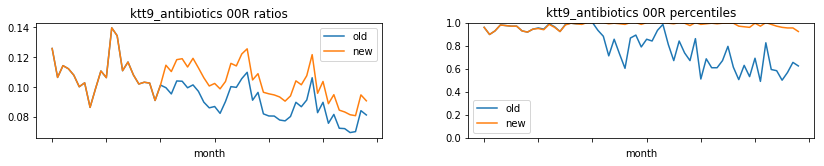

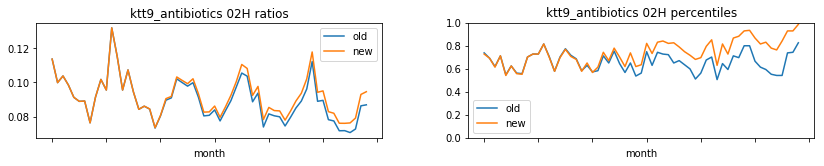

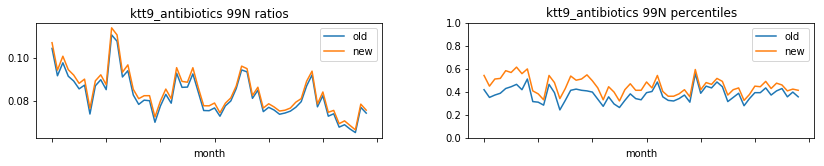

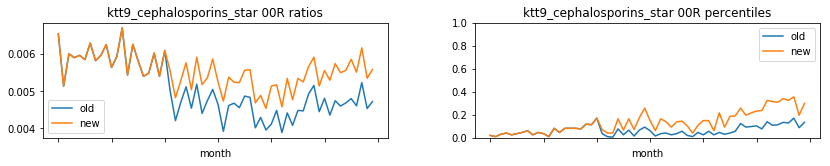

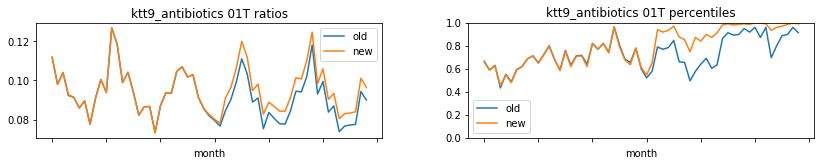

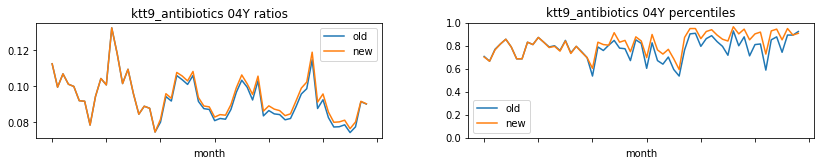

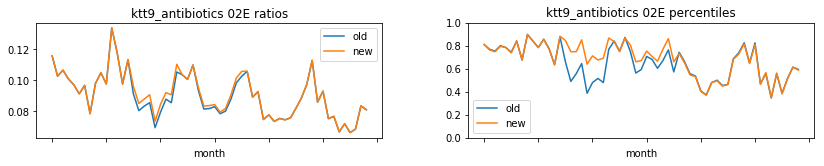

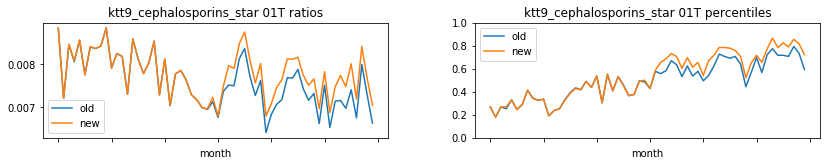

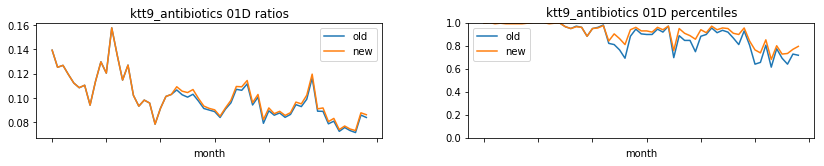

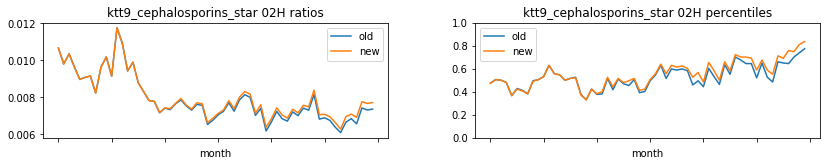

In [19]:
for measure_id, ccg_id in percentile_diff_by_measure_and_ccg.sort_values(ascending=False).head(10).index:
    plot_ratios_and_percentiles(df, measure_id, ccg_id)